# Introdução

A função de Rastrigin apresenta um desafio interessante para algoritmos de otimização, pois possui muitos mínimos locais e um mínimo global em (0, 0), sendo uma função multimodal e não convexa. A função de Rastrigin é definida por:

\begin{equation}
f(x) = An + \sum_{i=1}^{n} \left[ x_i^2 - A \cos(2\pi x_i) \right]
\end{equation}

Neste trabalho será implementado um algoritmo de evolução diferencial para otimizar a função de Rastrigin.

In [142]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas import Series
from benchmark_functions import Rastrigin

# Função Objetivo

A função objetivo aqui utilizada possui um domíni estabelecido para o problema de otimização, onde $x_i \in [-5.12, 5.12]$ para todo $i$.

Para representações reais do problema, tal qual o algoritmo de evolução diferencial, é necessário utilizar uma função de penalição para valores fora do domínio. A função de penalição utilizada é a de restrição quadrática, que penaliza valores fora do domínio com um valor proporcional ao quadrado da diferença.

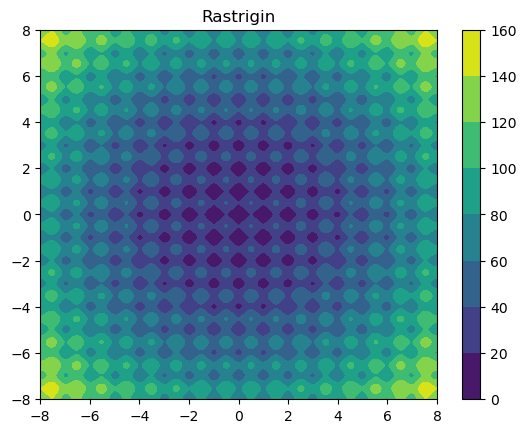

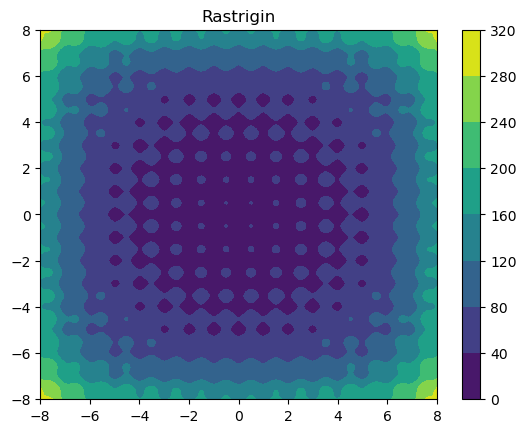

In [143]:
rastringin = Rastrigin(2)

points = np.linspace(-8, 8, 1000)

values = [rastringin([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

def rastringin_constrained_generator(rastringin):
    # Método utilizado: Penalização com parâmetro de penalização = 1000
    # Função de penalização 1: p * max(0, (x - 5.12))²
    # Função de penalização 2: p * max(0, (-x - 5.12))²
    # Obs: Por não ser realmente um problema de otimização convexa, iremos deixar o p fixado em 10, o que
    # não é um problema por sabermos que os mínimos locais são maiores que o global.
    p = 10
    def wrapper(x):
        return rastringin(x) + p * sum([max(0, (x_i - 5.12))**2 for x_i in x]) + p * sum([max(0, (-x_i - 5.12))**2 for x_i in x])
    
    return wrapper

rastringin_constrained = rastringin_constrained_generator(rastringin)

values = [rastringin_constrained([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

# Função em N=10

A função utilizada no problema real possui 10 dimensões, ou seja, $n=10$.

In [144]:
rastringin = Rastrigin(10)

rastringin_constrained = rastringin_constrained_generator(rastringin)

# Criação da População

Para iniciar a **população**, será utilizada uma amostragem aleatória uniforme no domínio da função. O tamanho da população será de 100 indivíduos.

In [145]:
def init_population(_mu:int = 100, n:int = 10):
    population = []
    for i in range (_mu):
        population.append([rd.uniform(-5.12, 5.12) for _ in range(n)])
    return population

# Mutação Diferencial

A mutação diferencial é uma operação que cria um vetor mutante a partir de três vetores da população. A fórmula do algoritmo canônico para a mutação é:

\begin{equation}
v_{i,G} = x_{r1,G} + F \cdot (x_{r2,G} - x_{r3,G})
\end{equation}

Onde $v_{i,G}$ é o vetor mutante, $x_{r1,G}$, $x_{r2,G}$ e $x_{r3,G}$ são vetores da população, $F$ é um fator de escala e $i$ é o índice do vetor mutante.

Neste trabalho, iremos testar também a mutação diferencial com estratégia de uso da melhor solução da população e da solução média da população. Isto possibilitará um estudo comparativo entre as estratégias.

As equações respectivas para as mutações são:

\begin{equation}
v_{i,G} = x_{best,G} + F \cdot (x_{r2,G} - x_{r3,G})
\end{equation}

\begin{equation}
v_{i,G} = x_{mean,G} + F \cdot (x_{r2,G} - x_{r3,G})
\end{equation}

## Cruzamento Binomial

O cruzamento binomial é uma operação que combina o vetor mutante com o vetor alvo. A fórmula para o cruzamento é:

\begin{equation}
u_{i,j,G} = \begin{cases} v_{i,j,G} & \text{se } rand(0, 1) \leq CR \text{ ou } j = rand(1, n) \\ x_{i,j,G} & \text{caso contrário} \end{cases}
\end{equation}

Onde $u_{i,j,G}$ é o vetor filho, $v_{i,j,G}$ é o vetor mutante, $x_{i,j,G}$ é o vetor alvo, $CR$ é a taxa de cruzamento e $j$ é o índice do vetor filho.

In [146]:
def mutate_pop(pop, F, strategy="canonical"):
    # NOTE: Nada impede de o operador de mutação combinado com o de recombinção gerar um indivíduo inválido,
    # porém, como a função de penalização é bem definida, o indivíduo inválido será penalizado.
    children = []
    for i in range(len(pop)):

        # não posso ter a == b; a == c; a, b ou c == i
        pop_without_i = pop.copy()
        pop_without_i.pop(i)
        a, b, c = rd.sample(pop_without_i, 3)
        if strategy == "canonical":
            child = [a[i] + F * (b[i] - c[i]) for i in range(len(a))]
        elif strategy == "best":
            best = min(pop, key=rastringin_constrained)
            child = [best[i] + F * (b[i] - c[i]) for i in range(len(a))]
        elif strategy == "average":
            average = np.mean(pop, axis=0)
            child = [average[i] + F * (b[i] - c[i]) for i in range(len(a))]
        else:
            raise ValueError("Invalid strategy")
        
        children.append(child)

    return children

def crossover(pop, children, crossover_rate):
    k = rd.randint(0, len(pop[0]))
    children = [[children[i][j] if rd.random() < crossover_rate or j == k else pop[i][j] for j in range(len(pop[0]))] for i in range(len(pop))]
    return children

# Seleção

A seleção é uma operação que escolhe o vetor alvo ou o vetor filho para a próxima geração. A fórmula para a seleção é:

\begin{equation}
x_{i,G+1} = \begin{cases} v_{i,G} & \text{se } f(v_{i,G}) \leq f(x_{i,G}) \\ x_{i,G} & \text{caso contrário} \end{cases}
\end{equation}

In [147]:
def selection(pop, children):
    return [min(pop[i], children[i], key=rastringin_constrained) for i in range(len(pop))]

# Função de Teste

In [148]:
def find_best_solution(mutation_strategy, max_gens=100):
    pop = init_population()

    current_generation = 0
    fitness_pop_vectors = []

    while True:
        fitness_pop = [rastringin_constrained(sol) for sol in pop]
        fitness_pop_vectors.append(min(fitness_pop))

        if 0 in fitness_pop or current_generation >= max_gens:
            break

        mutated_pop = mutate_pop(pop, 0.5, mutation_strategy)

        crossover_pop = crossover(pop, mutated_pop, 0.5)

        pop = selection(pop, crossover_pop)

        current_generation += 1

    best_solution = pop[np.argmin(fitness_pop)]
    
    best_solution_fitness = min(fitness_pop)
    
    return best_solution, best_solution_fitness, current_generation, fitness_pop_vectors

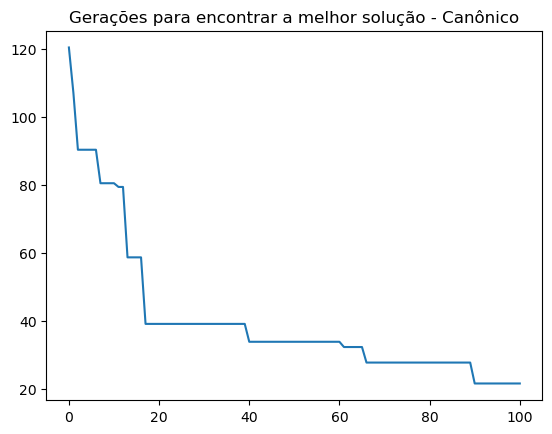

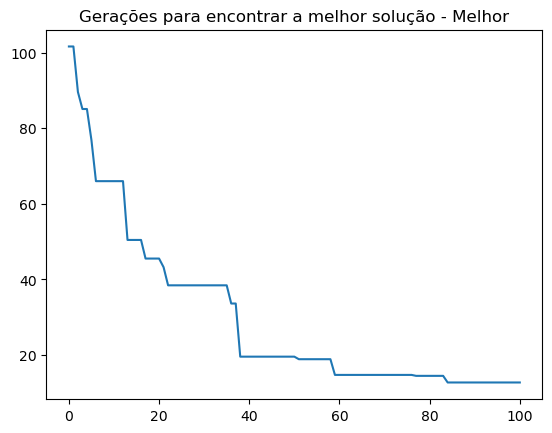

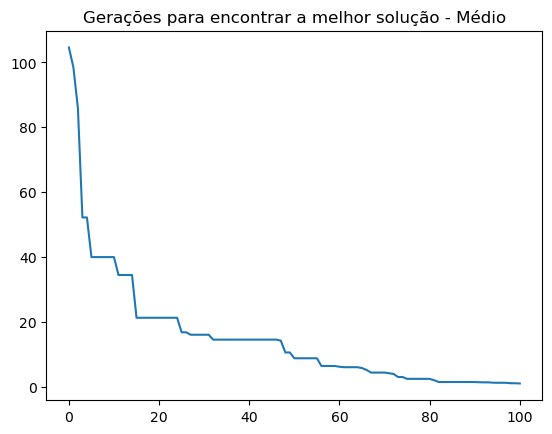

In [149]:
best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(mutation_strategy="canonical", max_gens=100)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Canônico")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(mutation_strategy="best", max_gens=100)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Melhor")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(mutation_strategy="average", max_gens=100)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Médio")
plt.show()

# Conclusões

Todas as estratégias de mutação e cruzamento foram testadas e comparadas, sendo que o resultado de ambas foi positivo. A estratégia de mutação com a solução média obteve o melhor resultado e teve uma otimização mais suave, enquanto a estratégia de mutação com a melhor solução possuiu um maior tempo de processamento por ter de avaliar a função de Rastringin para cada indivíduo da população.

Este resultado provavelmente ocorreu pelo fato de que a solução ótima da função ocorre na origem, e a solução média da população tende a se aproximar da origem mais rapidamente do que a melhor solução ou uma solução aleatória.